In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from scipy.ndimage import rotate, gaussian_filter
import os
import random




In [ ]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DATASET = "emnist/balanced"
BATCH_SIZE = 128
CNN_EPOCHS = 8
K_FOLDS = 5
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
def load_char_dataset(name, limit=None):
    if name.lower() == "mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        x_train, x_test = x_train.astype("float32")/255.0, x_test.astype("float32")/255.0
        x_train = x_train[..., None]; x_test = x_test[..., None]
        num_classes = len(np.unique(y_train))
        img_shape = x_train.shape[1:]
        label_map = list(map(str, range(10)))
    else:
        ds_train, ds_test = tfds.load(name, split=['train','test'], as_supervised=True)
        builder = tfds.builder(name)
        label_map = builder.info.features['label'].names

        def prep(ds, limit):
            ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, tf.cast(y, tf.int64)))
            if limit: ds = ds.take(limit)
            xs, ys = [], []
            for img, lbl in tfds.as_numpy(ds):
                xs.append(img)
                ys.append(lbl)
            xs = np.array(xs)
            ys = np.array(ys)
            if xs.ndim == 3: xs = xs[..., None]
            return xs, ys

        x_train, y_train = prep(ds_train, limit)
        x_test, y_test = prep(ds_test, None)
        num_classes = int(y_train.max() + 1)
        img_shape = x_train.shape[1:]
    return (x_train, y_train), (x_test, y_test), num_classes, img_shape, label_map


In [ ]:
def deskew(image):
    coords = np.array(np.nonzero(image))
    cov = np.cov(coords)
    evals, evecs = np.linalg.eigh(cov)
    angle = np.arctan2(evecs[0,0], evecs[1,0])
    return rotate(image, angle*180/np.pi, reshape=False, order=1)



In [ ]:
def denoise(image, sigma=0.5):
    return gaussian_filter(image, sigma=sigma)




In [ ]:
def preprocess_images(x):
    x_proc = np.empty_like(x, dtype='float32')
    for i in range(len(x)):
        img = deskew(x[i].squeeze())
        img = denoise(img)
        x_proc[i] = img[..., None]
    return x_proc



In [ ]:
def show_image_grid(x, y=None, title=None, n=9):
    n = min(n, len(x))
    cols = min(5, n)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        if y: plt.title(y[i])
        plt.axis('off')
    if title: plt.suptitle(title)
    plt.show()

Loaded dataset: train (112800, 28, 28, 1), test (18800, 28, 28, 1), classes 47


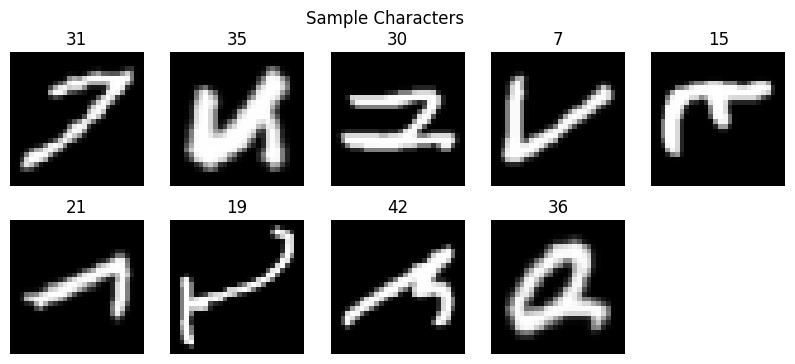

In [9]:
(char_x, char_y), (char_x_test, char_y_test), NUM_CLASSES, IMG_SHAPE, LABEL_MAP = load_char_dataset(DATASET)
print(f"Loaded dataset: train {char_x.shape}, test {char_x_test.shape}, classes {NUM_CLASSES}")

show_image_grid(char_x, [LABEL_MAP[i] for i in char_y], title="Sample Characters")


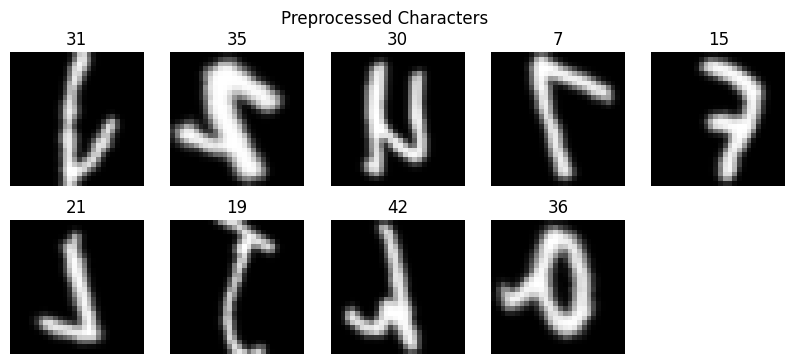

In [10]:

char_x_pre = preprocess_images(char_x)
char_x_test_pre = preprocess_images(char_x_test)
show_image_grid(char_x_pre, [LABEL_MAP[i] for i in char_y], title="Preprocessed Characters")

In [11]:
# ------------------ CNN ------------------
def build_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = keras.layers.MaxPool2D(2)(x)
    x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = keras.layers.MaxPool2D(2)(x)
    x = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = keras.layers.MaxPool2D(2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [12]:
def train_cnn_kfold(x, y, k=K_FOLDS):
    kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
    fold = 1
    all_accuracies = []
    for train_idx, val_idx in kf.split(x):
        x_tr, x_val = x[train_idx], x[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1
        )
        datagen.fit(x_tr)

        model = build_cnn(IMG_SHAPE, NUM_CLASSES)
        model.fit(datagen.flow(x_tr, y_tr, batch_size=BATCH_SIZE),
                  validation_data=(x_val, y_val),
                  epochs=CNN_EPOCHS, verbose=2)
        val_acc = model.evaluate(x_val, y_val, verbose=0)[1]
        print(f"Fold {fold} Validation Accuracy: {val_acc:.4f}")
        all_accuracies.append(val_acc)
        fold += 1

    print(f"Average K-Fold Accuracy: {np.mean(all_accuracies):.4f}")
    model.save(os.path.join(MODEL_DIR, "cnn_model_final.h5"))
    return model


In [13]:
def evaluate_cnn(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nCNN Test Accuracy: {test_acc:.4f}")

    y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap='Blues', xticklabels=LABEL_MAP, yticklabels=LABEL_MAP, annot=True, fmt=".2f")
    plt.title('Normalized CNN Confusion Matrix')
    plt.show()
    print(classification_report(y_test, y_pred, zero_division=0, target_names=LABEL_MAP))

    per_char_acc = np.zeros(NUM_CLASSES)
    for i in range(NUM_CLASSES):
        idx = (y_test == i)
        per_char_acc[i] = (y_pred[idx] == i).mean()
    plt.figure(figsize=(12,3))
    sns.barplot(x=LABEL_MAP, y=per_char_acc)
    plt.xticks(rotation=90)
    plt.ylabel("Accuracy")
    plt.title("CNN Per-Character Accuracy")
    plt.show()


In [14]:
def show_cnn_predictions(model, x, y, n=12):
    plt.figure(figsize=(14,2))
    for i in range(n):
        p = np.argmax(model.predict(x[i:i+1], verbose=0), axis=1)[0]
        plt.subplot(1, n, i+1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.title(f"P:{LABEL_MAP[p]}\nT:{LABEL_MAP[y[i]]}")
        plt.axis('off')
    plt.suptitle("CNN Sample Predictions")
    plt.show()


Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


705/705 - 33s - 46ms/step - accuracy: 0.4773 - loss: 1.8326 - val_accuracy: 0.7389 - val_loss: 0.8369
Epoch 2/8
705/705 - 27s - 39ms/step - accuracy: 0.6761 - loss: 1.0465 - val_accuracy: 0.7806 - val_loss: 0.6734
Epoch 3/8
705/705 - 26s - 37ms/step - accuracy: 0.7163 - loss: 0.8972 - val_accuracy: 0.7969 - val_loss: 0.6144
Epoch 4/8
705/705 - 26s - 37ms/step - accuracy: 0.7413 - loss: 0.8125 - val_accuracy: 0.8044 - val_loss: 0.5790
Epoch 5/8
705/705 - 27s - 39ms/step - accuracy: 0.7563 - loss: 0.7587 - val_accuracy: 0.8197 - val_loss: 0.5355
Epoch 6/8
705/705 - 28s - 39ms/step - accuracy: 0.7680 - loss: 0.7216 - val_accuracy: 0.8241 - val_loss: 0.5313
Epoch 7/8
705/705 - 27s - 38ms/step - accuracy: 0.7774 - loss: 0.6931 - val_accuracy: 0.8245 - val_loss: 0.5181
Epoch 8/8
705/705 - 27s - 39ms/step - accuracy: 0.7804 - loss: 0.6704 - val_accuracy: 0.8325 - val_loss: 0.5014
Fold 1 Validation Accuracy: 0.8325
Epoch 1/8
705/705 - 30s - 43ms/step - accuracy: 0.4825 - loss: 1.8190 - val_acc

Fold 5 Validation Accuracy: 0.8375
Average K-Fold Accuracy: 0.8281

CNN Test Accuracy: 0.8294


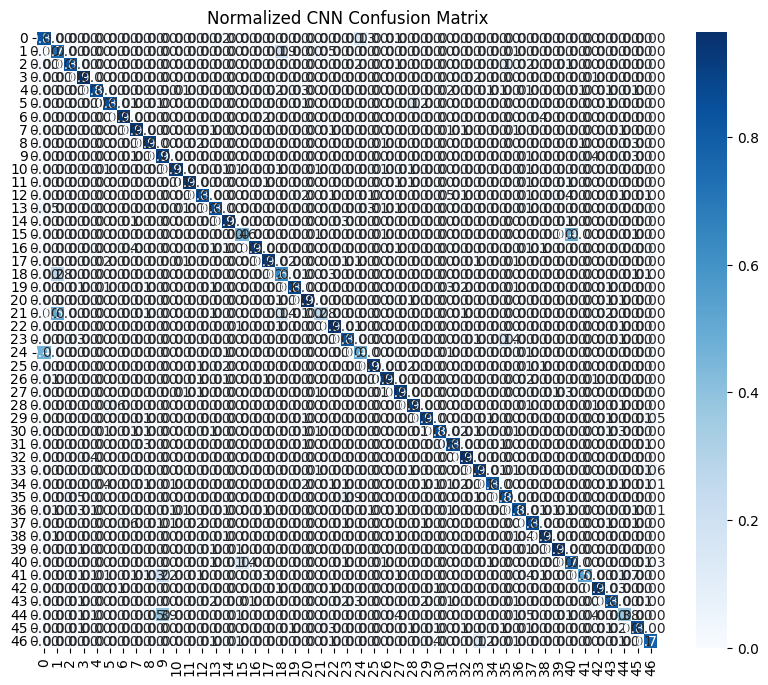

              precision    recall  f1-score   support

           0       0.61      0.83      0.70       400
           1       0.49      0.74      0.59       400
           2       0.84      0.83      0.84       400
           3       0.93      0.96      0.95       400
           4       0.89      0.84      0.86       400
           5       0.91      0.85      0.88       400
           6       0.86      0.93      0.89       400
           7       0.90      0.94      0.92       400
           8       0.90      0.92      0.91       400
           9       0.59      0.90      0.71       400
          10       0.94      0.92      0.93       400
          11       0.91      0.94      0.92       400
          12       0.91      0.84      0.87       400
          13       0.89      0.84      0.87       400
          14       0.94      0.94      0.94       400
          15       0.73      0.46      0.56       400
          16       0.91      0.91      0.91       400
          17       0.92    

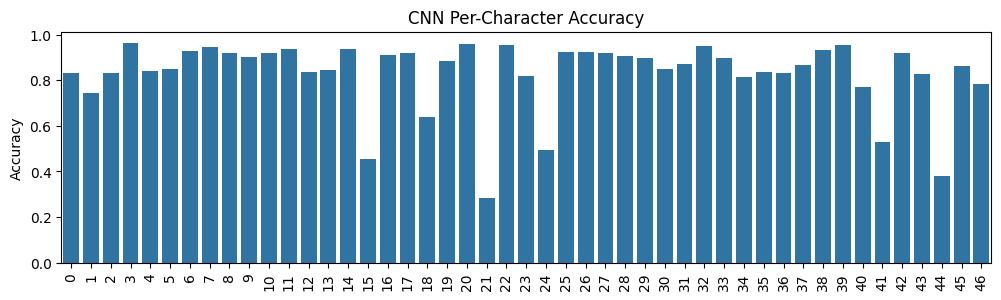

In [15]:
cnn_model = train_cnn_kfold(char_x_pre, char_y)
evaluate_cnn(cnn_model, char_x_test_pre, char_y_test)


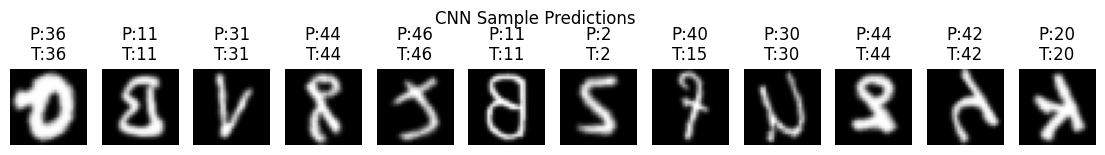

In [16]:
show_cnn_predictions(cnn_model, char_x_test_pre, char_y_test, n=12)

